##Paso 1. Carga de Datos
Descripción

En este paso se carga la tabla reviews desde el catálogo de Databricks utilizando Spark.

####Esta tabla contiene reseñas de productos de Amazon e incluye información como:

Identificador del producto

Identificador del usuario

Calificación (Score)

Número de votos útiles

Texto de la reseña

####Procesamiento Distribuido

Al utilizar spark.table() trabajamos en un entorno distribuido, lo que permite procesar grandes volúmenes de datos.

In [0]:
df = spark.table("workspace.default.reviews")

In [0]:
display(df)

Id ProductId UserId ProfileName HelpfulnessNumerator HelpfulnessDenominator Score Time Summary Text 378465 B008FHUGNQ A2UPPLL368TXRJ JuicyLucy 0 1 1 1323475200 Not unique I read many reviews before buying both Jet Fuel and Black Tiger because I really wanted an extra strong k-cup brew. I hate to say this but neither of these brews are stronger than any other "extra bold" brews I have tried. If you get this just know that you still need to use a smaller amount of water to make a strong cup of bold tasting coffee. I think the new Starbucks bold brews actually make a stronger cup of coffee. 378466 B008FHUGNQ A4FKMNHF0XWTS Richard Frederick "Run Coach" 0 1 1 1322524800 spewing coffee grounds all over these pods are defective . They spew coffee grounds all over the place and in the cup of coffee. I use others and this is the only one I've had a problem with! 378467 B008FHUGNQ A24V0SRCB8XBAC James B. Williams 0 1 1 1322179200 Jet Fuel K - Cups, not the best.... I buy K-Cups from Amazon regularly but the Jet Fuel Cup are not very good....I would stay with Green Mountian Brand or some of the other name brands........ 378468 B008FHUGNQ AH4OIDKO16KJ7 Aaron Edwards 0 1 2 1315353600 Just not the same... Those of you who lived in Portland during the 80s and 90s remember the real coffee people, before they sold their shops. This, simply put, is not the same coffee. I think I'll just go to the airport, or better yet, Jim and Patty's instead. 378469 B008FHUGNQ A37VQFMLKSCNBG mphilip 0 1 2 1304985600 Weak I read the reviews for this coffee and bought it based on that. I can not say that I am impressed. This coffee does not have the nice aroma that the Gloria Jeans black Gold had nor does it have any taste. Not impressed. 378470 B008FHUGNQ A8W8A8SXN3MGD emunoz 0 1 3 1295827200 Price Increase The price just increased by about $6 for 50 k-cups. What's that about, I've been purchasing this coffee for about a year, with automatic subscription every 2 months and now I get a price hike. Not too happy about it - need to start shopping around!!!!!!! 378471 B008FHUGNQ A3UZLUWFTAZQ2B Karen M Lane 0 1 1 1295308800 Defective K cups After trying all differant varieties of k cups this one has defective seals.Many cups full of coffee grinds.I saw other reviews stateing the same save your money dont buy these!!!! 378472 B008FHUGNQ A1BN2GY1NDI7EJ Porter Yax 0 1 3 1287100800 Not bad at all! A little on the acrid side of bitter, but what else could you expect when you order a coffee named "Jet Fuel"? Definitely one of the best bang for your buck coffees available for the Keurig machines here on Amazon.com. I also loved the no hassle packaging, no extra stuff that will take up room in my recycling bin. I'd buy it again, but I will have to resupply my vanilla creamer stash waaaay more often. I usually like my coffee black but this one is a bit much! If you love super bold coffee, go for it! If you are a breakfast blend with cream and sugar kinda person, maybe opt for the Donut Shop K-Cups instead. 378473 B008FHUGNQ AXVB6MNDCXDR7 Bellaj28 0 1 3 1284076800 Jet Fuel Coffee K Cups The Coffee tastes great, but in ever box, there are at least one or two K-Cups that are defective; specifically, the the coffee grounds leak out into the coffee. 378474 B008FHUGNQ A1L862YXFOMT9T Redrock Shopper 0 1 3 1283731200 Great name; mediocre coffee I'm a great 'jet fuel' coffee person. So I figured I'd give "Jet Fuel" a try in my Keurig. My favorites are still Emeril's Big Bold and Timothy's Rain Forest Espresso. Unfortunately "Jet Fuel" is not as bold and full bodied and leaves a thin aftertaste that is not pleasant to my taste. Definitely will not be on my re-order list. 378475 B008FHUGNQ A1LC8FLXV8C9J3 MaRedFerrari 0 1 3 1282003200 Nothing crazy Besides the fact that this coffee is really dark and bitter there is nothing more to say about it. Great price though and I wanted to try it out so it's not bad. 378476 B008FHUGNQ A2M2EAZBFBHBNW Joseph M. Alba "joeschmoe5150" 0 1 2 127984320

##Paso 2, Agregación por usuario
El dataset original está a nivel de reseña.
Para segmentar clientes, necesitamos métricas por usuario.

Se agrupan los datos por UserId y se calculan:
Se agrupan los datos por **UserId** y se calculan las siguientes métricas:
- **total_reviews**: número total de reseñas hechas por el usuario  
- **avg_rating**: promedio de calificación  
- **max_rating**: calificación más alta dada  
- **min_rating**: calificación más baja dada 

In [0]:
from pyspark.sql.functions import avg, count, max, min

customer_df = df.groupBy("UserId").agg(
    count("Id").alias("total_reviews"),
    avg("Score").alias("avg_rating"),
    max("Score").alias("max_rating"),
    min("Score").alias("min_rating"),
    avg("HelpfulnessNumerator").alias("avg_help_num"),
    avg("HelpfulnessDenominator").alias("avg_help_den")
)

feature_df = feature_df.fillna(0)

In [0]:
customer_df.count()

256059

##Paso 3. Estadísticas generales del dataset

En Amazon Reviews:

HelpfulnessNumerator = cuántas personas marcaron la reseña como útil.

HelpfulnessDenominator = cuántas personas votaron en total.

- La media es alta (4.18):  la mayoría de reseñas son positivas.

- Hay variabilidad (desviación 1.31).

- Existen usuarios extremadamente críticos (1) y extremadamente positivos (5).

Nota: stddev() Qué tanto varían los datos
HelpfulnessNumerator = cuántas personas marcaron la reseña como útil.
HelpfulnessDenominator = cuántas personas votaron en total.

In [0]:
# Resumir las columnas numéricas principales
from pyspark.sql.functions import mean, min, max, stddev, col

num_stats = df.select(
    mean('Score').alias('mean_score'),
    stddev('Score').alias('stddev_score'),
    min('Score').alias('min_score'),
    max('Score').alias('max_score'),
    #Qué tanto varían los valores de HelpfulnessNumerator entre todas las reseñas.
    mean('HelpfulnessNumerator').alias('mean_help_num'),
    stddev('HelpfulnessNumerator').alias('stddev_help_num'),
    min('HelpfulnessNumerator').alias('min_help_num'),
    max('HelpfulnessNumerator').alias('max_help_num'),
    mean('HelpfulnessDenominator').alias('mean_help_den'),
    stddev('HelpfulnessDenominator').alias('stddev_help_den'),
    min('HelpfulnessDenominator').alias('min_help_den'),
    max('HelpfulnessDenominator').alias('max_help_den')
)
display(num_stats)

mean_score stddev_score min_score max_score mean_help_num stddev_help_num min_help_num max_help_num mean_help_den stddev_help_den min_help_den max_help_den 4.183198640523243 1.3104360248243063 1 5 1.7438174416927315 7.636512706820782 0 866 2.2288100708236724 8.289740293185586 0 923

##Paso 4. Creación del dataset final de features
Agrupar todas las reseñas que pertenecen al mismo usuario

Nota: coalesce() sirve para reemplazar valores nulos por otro valor.


In [0]:
from pyspark.sql.functions import coalesce
# Crear funciones para la agrupación en clústeres para cada usuario
feature_df = df.groupBy("UserId").agg(
    #Cuántas veces ese usuario ha comprado o reseñado
    count("Id").alias("total_reviews"),
    #Qué tan satisfecho es el cliente en promedio
    avg("Score").alias("avg_rating"),
    #La mejor experiencia que ha tenido ese cliente
    max("Score").alias("max_rating"),
    min("Score").alias("min_rating"),
    avg("HelpfulnessNumerator").alias("avg_help_num"),
    avg("HelpfulnessDenominator").alias("avg_help_den")
)
# Rellene cualquier valor nulo con 0
feature_df = feature_df.fillna(0)
display(feature_df.limit(10))

UserId total_reviews avg_rating max_rating min_rating avg_help_num avg_help_den A2CIY13TG5O291 2 2.0 2 2 0.0 0.0 A31J176KH7ZZEY 29 5.0 5 5 2.5172413793103448 2.896551724137931 AOS6V51CJM8NQ 3 5.0 5 5 0.0 0.0 A3VB7Y8FF8EQ50 1 1.0 1 1 4.0 6.0 A3ESUI9UBQ85C3 1 5.0 5 5 0.0 0.0 A2V4LEV9GUIYL6 3 5.0 5 5 0.6666666666666666 1.3333333333333333 A19LUT6NUQZF3A 12 2.0 5 1 0.0 0.6666666666666666 AWC6RMU31978F 22 4.454545454545454 5 1 0.09090909090909091 0.2727272727272727 A22363SZW4OLJ6 26 5.0 5 5 0.9615384615384616 0.9615384615384616 A8DR6JIHBM6K5 31 2.4516129032258065 5 2 1.3870967741935485 1.6774193548387097

##Paso 5. Vectorizacion y normalización
K-Means no trabaja con columnas separadas.
Necesita un vector numérico.
VectorAssembler combina las variables en una sola columna llamada features_raw.

K-Means usa distancia euclidiana.
Si una variable tiene valores muy grandes (ej. total_reviews) dominará el clustering.
StandardScaler estandariza:
- media = 0
- desviación estándar = 1


In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

# Assemble features
vec_assembler = VectorAssembler(
    inputCols=["total_reviews","avg_rating","max_rating","min_rating","avg_help_num","avg_help_den"],
    outputCol="features_raw"
)
#Crea una nueva columna
data_vec = vec_assembler.transform(feature_df)

# Scale features
#K-Means usa distancia euclidiana
#Todas las variables quedan centradas en 0 y con varianza 1.
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(data_vec)
data_scaled = scaler_model.transform(data_vec)

# Fit KMeans
#k=4: 4 segmentos
#seed=42: reproducibilidad
kmeans = KMeans(k=4, seed=42)
lr_model = kmeans.fit(data_scaled)
clusters = lr_model.transform(data_scaled)

display(clusters.select("UserId", "prediction", "total_reviews", "avg_rating", "avg_help_num"))

UserId prediction total_reviews avg_rating avg_help_num A2CIY13TG5O291 3 2 2.0 0.0 A31J176KH7ZZEY 0 29 5.0 2.5172413793103448 AOS6V51CJM8NQ 1 3 5.0 0.0 A3VB7Y8FF8EQ50 3 1 1.0 4.0 A3ESUI9UBQ85C3 1 1 5.0 0.0 A2V4LEV9GUIYL6 1 3 5.0 0.6666666666666666 A19LUT6NUQZF3A 0 12 2.0 0.0 AWC6RMU31978F 0 22 4.454545454545454 0.09090909090909091 A22363SZW4OLJ6 0 26 5.0 0.9615384615384616 A8DR6JIHBM6K5 0 31 2.4516129032258065 1.3870967741935485 ARVPIAUAVTCXM 1 3 5.0 0.0 A24DILCLG09VMH 1 1 5.0 0.0 A1R49WC47L8TQX 1 1 5.0 5.0 A1FHFJJCLVQRPX 0 3 3.6666666666666665 3.0 AZ40IMISN41W9 1 1 5.0 0.0 A31N6KB160O508 0 162 4.5 1.191358024691358 AIXWP58R7K2XZ 1 1 5.0 0.0 A351QGZ5S8PTBL 0 6 4.166666666666667 0.3333333333333333 AKRSGOFSU2C3C 1 1 5.0 0.0 AKA67X06GK439 0 3 3.6666666666666665 4.333333333333333 AV794BCR72KFT 1 1 5.0 0.0 A3JPPZO5G81R5F 0 3 2.3333333333333335 1.6666666666666667 A2NGL1FOEIUWQP 1 1 5.0 0.0 A12KAHN3D869EW 1 1 5.0 0.0 A1GZ4I6ASIOVI2 1 1 5.0 0.0 A1XJV3HL8LO916 3 1 2.0 4.0 A395CPAOJAQAAJ 0 4 3.0 0.0 A1QCHW11QUIOV5 1 1 5.0 0.0 A3NT1VMAVGMK1B 1 5 5.0 4.2 A3DQDXB1KP3N2F 1 1 5.0 2.0 A1YMXGQQT7YWMN 0 9 4.666666666666667 0.2222222222222222 A39NRLN369P8NP 1 10 5.0 12.0 A1GVFL2MQRYEQA 1 1 5.0 2.0 A2WOVFJ073E0G6 0 1 4.0 1.0 A3VEDVQGMBZ0HM 1 11 5.0 18.0 A2M0GA6IKFINRJ 3 11 1.0 2.0 A1RS1UDR2UU5NO 0 1 4.0 0.0 A35NJ3LSF0HFIF 1 5 5.0 0.4 AL7J8EKHDBX49 0 6 4.333333333333333 0.16666666666666666 A2BNTSSB8GO924 1 2 5.0 0.0 A1CUE4L5Z0V98D 0 14 4.571428571428571 2.357142857142857 A3JY9QGX3WHF63 1 3 4.666666666666667 0.3333333333333333 A26NEQFG6FIBXH 0 9 4.666666666666667 17.333333333333332 AS03Z0FK07AML 1 3 5.0 0.0 A2LN147W04LIVV 0 8 3.75 0.25 A1WH998KDXZB7A 0 16 3.875 0.5625 A1328E7Y9FJNGP 1 7 5.0 3.4285714285714284 A1J5Z5MX1O5SRZ 1 4 4.75 0.75 A2USKG8N6F43AR 1 4 5.0 0.25 A1KRMP4A6RAQ2S 1 1 5.0 0.0 A1XGFY7TQNR2OV 0 1 4.0 0.0 A2S4XBH2352WHJ 0 1 3.0 1.0 A1Q1T811N4IY3Z 0 8 3.875 0.25 A15YB0DWQ815SY 1 4 4.75 2.5 A371AP43OX0K4V 0 7 3.5714285714285716 0.2857142857142857 A2TBZAC0XYHLIB 0 6 4.166666666666667 0.0 ASJLXOX1VD4DF 0 13 4.3076923076923075 14.384615384615385 AOBVDFEH2PBK3 1 2 5.0 0.0 A3GG7RFQK9HKXK 3 2 1.5 0.0 AP448FMCNTM4Z 1 3 4.666666666666667 2.3333333333333335 A1JK4GTNO3GUDG 0 1 4.0 0.0 A33L6K2HC7P6IX 1 6 5.0 0.6666666666666666 A3NID9D9WMIV01 0 47 4.404255319148936 5.702127659574468 A225VY7GWJRDVN 1 1 5.0 0.0 A2ZJSLWT0IINU8 0 4 4.0 2.25 A2K54Q33OP6EJG 0 5 4.0 0.0 AIZH0RKLZKLZG 1 6 5.0 0.0 A3KJFAHSF48KH3 0 15 4.666666666666667 2.4 ACHAR1K24UR2A 1 2 4.5 6.0 A3OGYXV9S7MJHM 0 95 4.484210526315789 0.12631578947368421 A1QP17D4X705C 0 10 4.4 0.8 A1GEMT7FSFKPDD 1 7 5.0 19.0 A2X7UW1NRE7MS3 1 7 5.0 2.0 A2X50XV8GRZ4HG 1 8 5.0 0.875 A3EFA2GQ6QSN6R 0 13 4.6923076923076925 0.0 A2WCLT9E6BHQ1 1 1 5.0 0.0 A274OIG0K3Y411 1 9 5.0 0.0 A15281ZG5VT4GA 1 9 5.0 3.0 A4SABKZH3CMGC 1 1 5.0 1.0 A202UTW6KYIJJZ 0 1 4.0 4.0 A34TNH973Q9XT0 0 18 2.7777777777777777 0.6666666666666666 A2VU47FRZWAPL5 1 10 5.0 0.0 A16FMUZ4ZNGASC 0 3 4.333333333333333 0.0 A1FAX09PALQUQ1 1 1 5.0 0.0 A8RIOFEK4ZP5G 1 1 5.0 4.0 A22UJL9OWU58FI 0 2 4.0 1.0 A1N4E40SX53UWF 1 1 5.0 1.0 A2CUSLPG7E6P6 1 1 5.0 2.0 A1NZWHTWOFVGXL 1 5 5.0 0.2 A2AV95T2UZIVPD 1 1 5.0 3.0 A4D9AIUP1NNIY 0 10 3.5 0.7 A1CDRS1GDBW2F7 0 5 4.0 1.4 A1KUOSQ1YZZFTU 0 10 3.5 1.1 A25P0QHG4A4GBF 1 3 5.0 0.0 A28RSJ75ST0BGM 0 7 4.428571428571429 1.5714285714285714 A1F6PDXFPGUSYO 1 3 5.0 1.3333333333333333 A123879TGBH5LB 0 6 4.5 1.8333333333333333 A2150074LCFKHV 0 1 3.0 0.0 A1F6BHEYB7R6R7 0 8 3.5 6.125 AB4680PNZK222 1 1 5.0 0.0 AP7GVV58B1EX8 1 2 5.0 1.0 A3EVUHG7ZXV42 3 1 1.0 1.0 AUYUCBW0MEXS4 1 2 5.0 0.0 A3E077BV7OTTTH 1 1 5.0 1.0 A2K98R710KL72Q 3 1 2.0 0.0 A399B3CFKMN8DV 1 1 5.0 0.0 A1RXLZY53ZQ6UT 0 11 4.909090909090909 1.6363636363636365 AZPK9GGECEVHX 1 1 5.0 1.0 A2PHCMQ03DOEWS 1 1 5.0 1.0 ACV7S00C013LP 0 2 3.0 0.5 A349DOC7GFJ4TQ 1 1 5.0 0.0 A30ARMF3JEKEJY 0 26 3.576923076923077 0.19230769230769232 AVDS9CNPV9FY9 1 2 5.0 0.0 AVY8BIM0KLKYY 0 9 4.0 1.1111111111111112 AQCK0L64XNZLE 1 9 5.0 0.0 AW6J9IILGOZY3 0 25 4.0 6.44 A12GQGDY8UFEKO 1 1 5.0 0.0 A2BB4

In [0]:
from pyspark.sql.functions import avg, count

summary = clusters.groupBy("prediction").agg(
    count("UserId").alias("num_users"),
    avg("total_reviews").alias("avg_reviews"),
    avg("avg_rating").alias("avg_rating"),
    avg("avg_help_num").alias("avg_help_num")
)

##Paso 6. Interpretar los segmentos como perfiles de cliente reales.

Se agrupa por 'prediction', que es el numero de clustes asignado por K-Means (0,1,2,3)

####Análisis
El clustering permitió identificar segmentos diferenciados basados en comportamiento de reseñas e impacto social, revelando un pequeño grupo altamente influyente, un segmento crítico con baja satisfacción, y una mayoría de clientes satisfechos pero con bajo nivel de interacción.

#####Cluster 2- Segmento:
Tiene pocos usuarios (58),  un Rating medio (3.4) y un promedio de votos útiles (305). por lo que este grupo muy especial y son usuarios muy influyentes.



In [0]:
# Resumir las estadísticas de usuario por clúster
summary = clusters.groupBy("prediction").agg(
    #Cuántos usuarios hay en ese clúster
    count("UserId").alias("num_users"),
    #En promedio, cuántas reseñas hace cada cliente del clúster.
    avg("total_reviews").alias("avg_reviews"),
    #Nivel promedio de satisfacción del grupo
    avg("avg_rating").alias("avg_rating"),
    #Cuántos votos útiles reciben sus reseñas en promedio
    avg("avg_help_num").alias("avg_help_num")
)
display(summary)

prediction num_users avg_reviews avg_rating avg_help_num 2 58 2.2586206896551726 3.41388440395187 305.4942432629839 3 36107 1.5261029717229346 1.3239053294558256 2.5789230740356808 0 58808 3.9892871718133587 3.687532377220082 1.535486598124957 1 161086 1.7296226860186483 4.982737341426024 1.499710872647611

####Gráfica de barras con promedio de reseñas por cluster.
######Análisis:
- Cluster 0 - (Superusuarios):
Es el grupo más destacado. Con un promedio de 4 reseñas por usuario, son los clientes más comprometidos. En un dataset de Amazon, estos podrían ser críticos profesionales, usuarios "Vine" o simplemente que compran y opinan frecuentemente.

- Cluster 2 - Los Usuarios Recurrentes:
Tienen un promedio cercano a 2.25 reseñas. No son tan activos como el Cluster 0, pero demuestran una lealtad clara a la plataforma. Son usuarios que ya pasaron la barrera de la "primera compra".

- Clusters 1 y 3:
Tienen los promedios más bajos (entre 1.5 y 1.7). Es probable que la gran mayoría de los usuarios en estos grupos solo hayan dejado una o dos reseñas. Son usuarios que solo opinan cuando algo les gusta o disgusta mucho, pero no tienen el hábito de reseñar.

Esto ayuda a:

- Diseñar campañas de fidelización

- Identificar clientes leales

- Detectar usuarios poco activos

Nota: 
summary es un DataFrame de Spark.
.toPandas() convierte el DataFrame distribuido (Spark) en uno local (pandas).


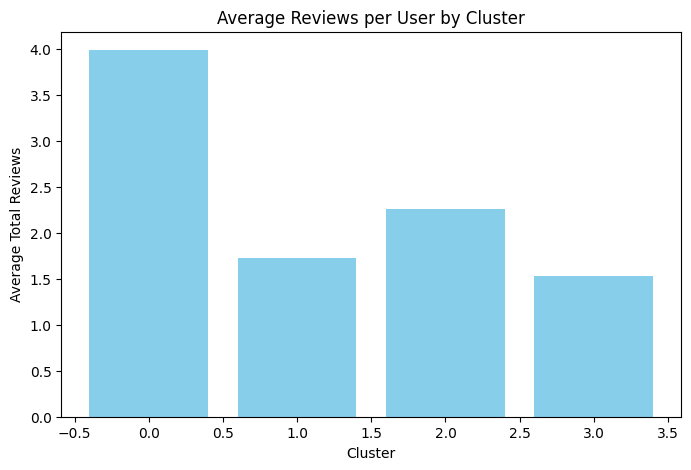

In [0]:
import matplotlib.pyplot as plt
summary_pd = summary.toPandas()
plt.figure(figsize=(8,5))
plt.bar(summary_pd['prediction'], summary_pd['avg_reviews'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Average Total Reviews')
plt.title('Average Reviews per User by Cluster')
#Renderiza el gráfico en pantalla.
plt.show()

####Boxplot con distribución de rating promedio por cluster.
#####Análisis
Cluster 0: Son usuarios consistentes. No regalan las 5 estrellas, pero tampoco son haters. Son el perfil del "consumidor racional" que pone 3 o 4 estrellas basándose en la realidad del producto. Tiene muchos puntos hacia abajo (hasta 1.0). Esto indica que algunos usuarios de este grupo tuvieron experiencias aisladas muy malas, pero su comportamiento general es moderado.
Cluster 2: Es el grupo con mayor varianza. Son usuarios que quizás escriben mucho (como vimos en la gráfica anterior, el Cluster 2 era activo), pero sus opiniones son muy polarizadas.

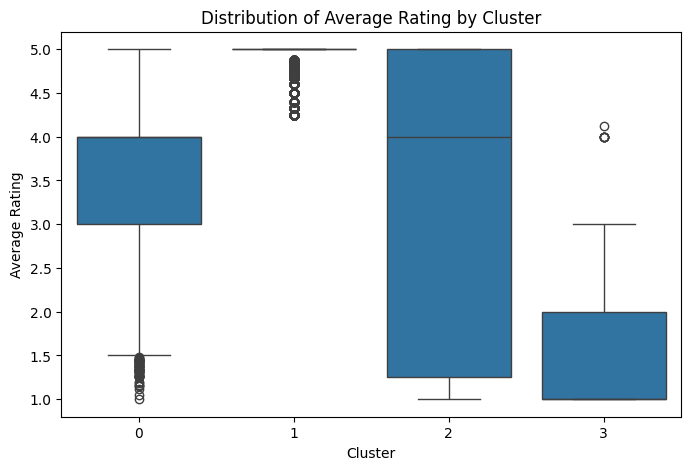

In [0]:
import seaborn as sns
clustered_pd = clusters.select('prediction', 'avg_rating').toPandas()
plt.figure(figsize=(8,5))
sns.boxplot(x='prediction', y='avg_rating', data=clustered_pd)
plt.xlabel('Cluster')
plt.ylabel('Average Rating')
plt.title('Distribution of Average Rating by Cluster')
plt.show()

####Visualización 2D usando PCA.
#####Análisis:
Nota: PCA (Principal Component Analysis), lo usamos para reducir dimensiones
PCA encuentra vectores propios (eigenvectors) de la matriz de covarianza.


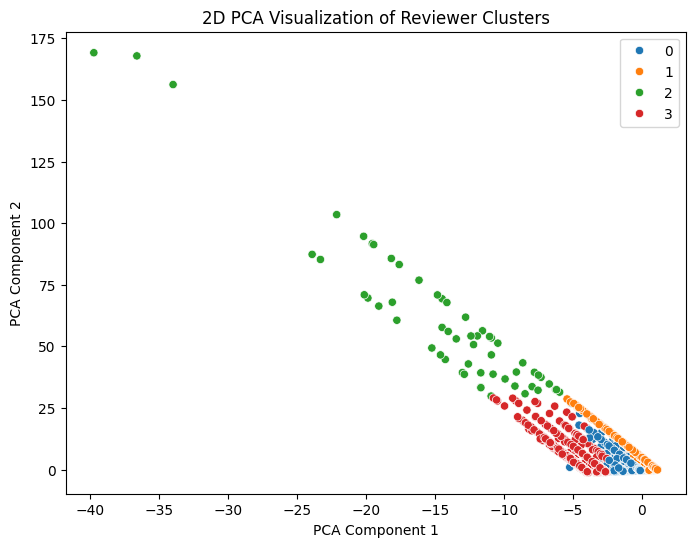

In [0]:
El análisis de esta visualización de PCA revela que el algoritmo K-Means ha logrado identificar estructuras muy claras, donde el Cluster 2 (verde) destaca como el grupo de comportamientos extremos o "superusuarios", alejándose significativamente del resto en ambos componentes debido a sus altos niveles de actividad y métricas de utilidad. Por otro lado, los Clusters 0, 1 y 3 forman una masa en la zona inferior derecha, lo que indica que comparten un perfil de uso más convencional; sin embargo, se mantienen separados entre sí siguiendo patrones diagonales que reflejan las variaciones en sus ratings promedio (desde los más satisfechos en el naranja hasta los detractores en el rojo).from pyspark.ml.feature import PCA
from pyspark.sql.functions import monotonically_increasing_id

# Apply PCA to reduce to 2D
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(data_scaled)
pca_result = pca_model.transform(data_scaled)

# Add row_id to both DataFrames to align prediction
pca_result_idx = pca_result.withColumn('row_id', monotonically_increasing_id())
clusters_idx = clusters.withColumn('row_id', monotonically_increasing_id())

# Join on row_id to bring in 'prediction'
pca_for_plot = pca_result_idx.join(clusters_idx.select('row_id', 'prediction'), on='row_id', how='inner')

# Collect to pandas
pca_pd = pca_for_plot.select('prediction', 'pca_features').toPandas()

# Split PCA columns
import numpy as np
pca_pd['pca1'] = pca_pd['pca_features'].apply(lambda x: x[0])
pca_pd['pca2'] = pca_pd['pca_features'].apply(lambda x: x[1])

plt.figure(figsize=(8,6))
sns.scatterplot(x='pca1', y='pca2', hue='prediction', data=pca_pd, palette='tab10')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Reviewer Clusters')
plt.legend()
plt.show()